<a href="https://colab.research.google.com/github/SerhiiAndreiko/HW_DATA_08/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [42]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [43]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [44]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

# Визначення класу нейромережі
class NN(tf.Module):
    def __init__(self, name=None, optimizer_type="adam"):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
        self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

        self.optimizer_type = optimizer_type
        self.optimizer = self.get_optimizer()

    def get_optimizer(self):
        if self.optimizer_type == "adam":
            return tf.optimizers.Adam(learning_rate)
        elif self.optimizer_type == "rmsprop":
            return tf.optimizers.RMSprop(learning_rate)
        elif self.optimizer_type == "sgd":
            return tf.optimizers.SGD(learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer_type}")

    def __call__(self, x):
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)
        return self.out_layer(x, activation=1)

In [45]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, dtype=tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))


In [46]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    gradients = g.gradient(loss, neural_net.trainable_variables)
    neural_net.optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))


In [47]:
# Навчання нейронної мережі

# Запуск тренування
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")
        loss_history.append(loss)
        accuracy_history.append(acc)

# Виведення фінальних результатів
final_pred_3 = neural_net(x_train)
final_loss_3 = cross_entropy(final_pred_3, y_train)
final_acc_3 = accuracy(final_pred_3, y_train)
print(f"Final Loss on Training Data: {final_loss_3}")
print(f"Final Accuracy on Training Data: {final_acc_3}")

Step: 100, Loss: 377.39202880859375, Accuracy: 0.6328125
Step: 200, Loss: 259.4441833496094, Accuracy: 0.734375
Step: 300, Loss: 225.68243408203125, Accuracy: 0.75390625
Step: 400, Loss: 167.15582275390625, Accuracy: 0.796875
Step: 500, Loss: 153.3642578125, Accuracy: 0.83984375
Step: 600, Loss: 131.58863830566406, Accuracy: 0.8828125
Step: 700, Loss: 82.8226089477539, Accuracy: 0.890625
Step: 800, Loss: 100.98652648925781, Accuracy: 0.8828125
Step: 900, Loss: 129.75132751464844, Accuracy: 0.87890625
Step: 1000, Loss: 105.06858825683594, Accuracy: 0.90234375
Step: 1100, Loss: 115.4808120727539, Accuracy: 0.87890625
Step: 1200, Loss: 88.51312255859375, Accuracy: 0.890625
Step: 1300, Loss: 106.22491455078125, Accuracy: 0.890625
Step: 1400, Loss: 43.64484405517578, Accuracy: 0.94921875
Step: 1500, Loss: 62.661903381347656, Accuracy: 0.921875
Step: 1600, Loss: 72.12352752685547, Accuracy: 0.9140625
Step: 1700, Loss: 66.79976654052734, Accuracy: 0.9453125
Step: 1800, Loss: 70.87995910644531

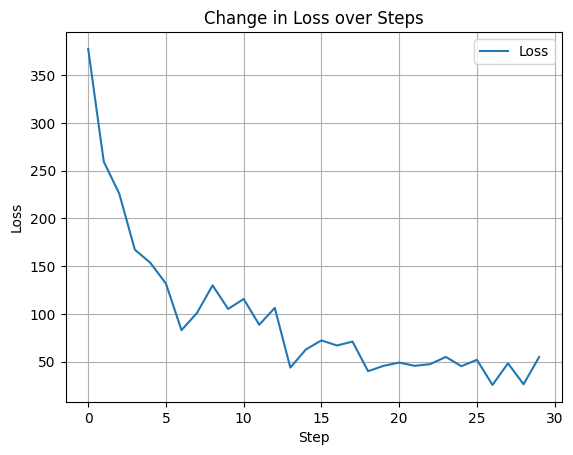

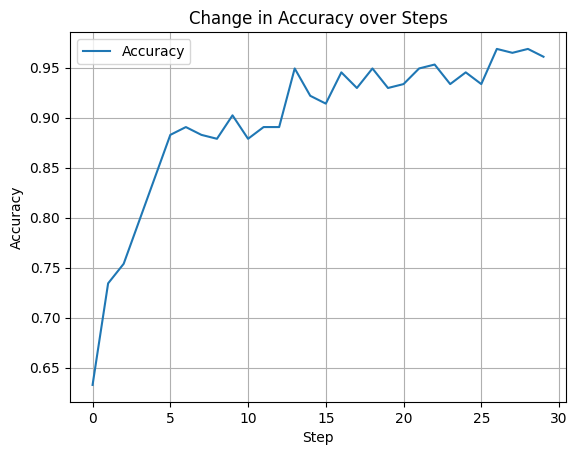

In [48]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Графіки зміни втрат та точності
plt.plot(loss_history, label='Loss')
plt.title('Change in Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.title('Change in Accuracy over Steps')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [49]:
# Оцінка точності на тренувальних та тестових даних
final_pred_train = neural_net(x_train)
final_acc_train = accuracy(final_pred_train, y_train)
print(f"Final Accuracy on Training Data: {final_acc_train}")

test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Accuracy on Test Data: {test_acc}")

Final Accuracy on Training Data: 0.9613166451454163
Accuracy on Test Data: 0.9258000254631042


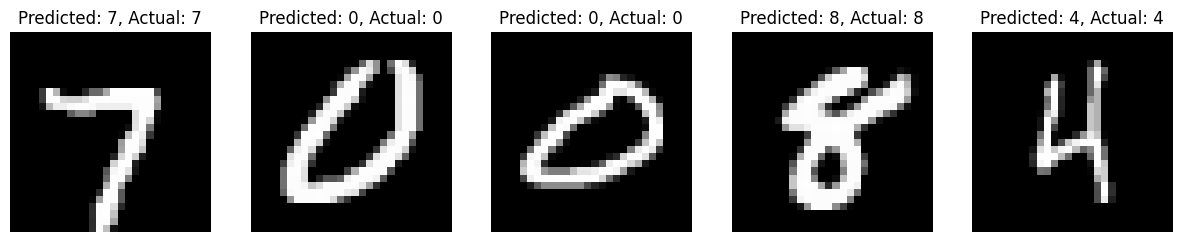

In [52]:
# Виберіть 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Передайте обрані зображення в нейронну мережу
predictions = neural_net(images_to_test)

# Виведіть зображення та випишіть поруч відповідь нейромережі
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, Actual: {labels_to_test[i]}")
    plt.axis('off')
plt.show()


# **Висновок: У нашому випадку, всі передбачені та фактичні мітки відповідають цифрі на зображенні, це означає, що нейромережа правильно класифікувала це зображення. Це є ознакою того, що модель працює ефективно та правильно розпізнає цифри на вхідних зображеннях.**
